## Import Libraries and Data

In [2]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_16-05-23.csv', firstRow=462, lastRow=468)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_160523_S463-468.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [3]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=476s; mass=44.76135000000001g
This equals a volume of 44.851m; expected was 45.008mL; error is 0.348%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0010000000000000002 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


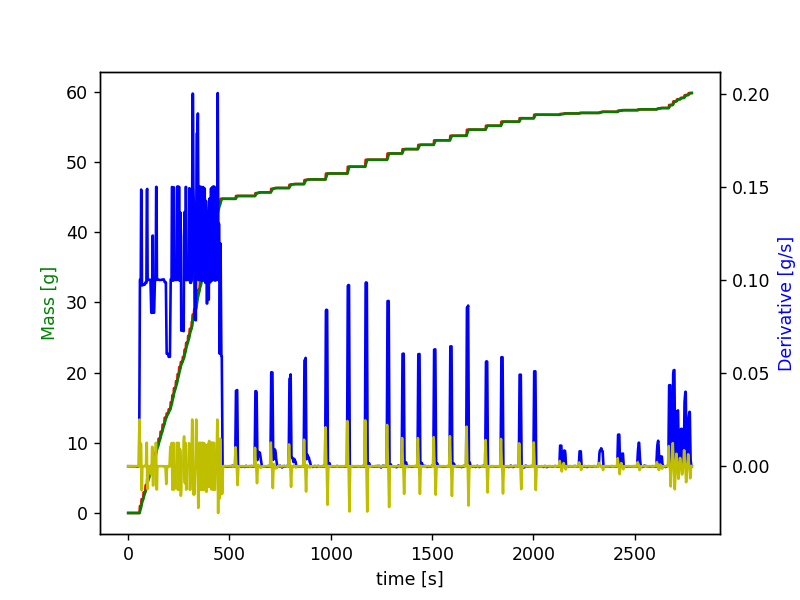

Addition of 0.409g Texapon SB 3 KC detected from 526s to 546s - expected volume = 0.795mL and actual volume = 0.367mL (resulting error is 53.842%)
Addition of 0.524g Plantapon LC 7 detected from 620s to 664s - expected volume = 0.612mL and actual volume = 0.496mL (resulting error is 19.01%)
Addition of 0.623g Plantapon LC 7 detected from 700s to 740s - expected volume = 0.612mL and actual volume = 0.59mL (resulting error is 3.589%)
Addition of 0.563g Plantacare 2000 detected from 790s to 834s - expected volume = 0.597mL and actual volume = 0.518mL (resulting error is 13.267%)
Addition of 0.664g Plantacare 2000 detected from 864s to 906s - expected volume = 0.597mL and actual volume = 0.611mL (resulting error is 2.342%)
Addition of 0.855g Dehyton MC detected from 970s to 1002s - expected volume = 0.842mL and actual volume = 0.786mL (resulting error is 6.703%)
Addition of 0.971g Dehyton PK 45 detected from 1078s to 1098s - expected volume = 0.952mL and actual volume = 0.921mL (resulting 

In [4]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.000390625 g/s^2


<IPython.core.display.Javascript object>


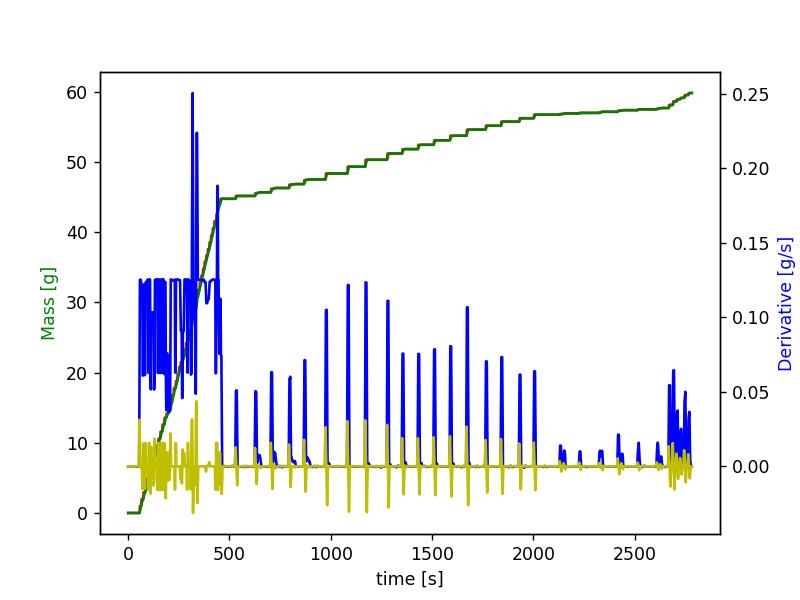

Addition of 0.19g Dehyquart CC6 detected from 2126s to 2164s - expected volume = 0.139mL and actual volume = 0.18mL (resulting error is 29.337%)
Addition of 0.079g Dehyquart CC6 detected from 2222s to 2240s - expected volume = 0.075mL and actual volume = 0.074mL (resulting error is 0.937%)
Addition of 0.163g Dehyquart CC6 detected from 2320s to 2348s - expected volume = 0.094mL and actual volume = 0.154mL (resulting error is 63.125%)
Addition of 0.237g Dehyquart CC6 detected from 2412s to 2448s - expected volume = 0.187mL and actual volume = 0.225mL (resulting error is 20.368%)
Addition of 0.123g Dehyquart CC6 detected from 2510s to 2532s - expected volume = 0.101mL and actual volume = 0.117mL (resulting error is 16.274%)
Addition of 0.193g Dehyquart CC6 detected from 2604s to 2640s - expected volume = 0.151mL and actual volume = 0.183mL (resulting error is 21.148%)


In [5]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

In [ ]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2780,2834,2844,2848,2862,2884,2906])

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_160523_S457-S462.csv', index=False)
actualMassFractions